In [1]:
import datetime
import time
import numpy as np
import pandas as pd
import dask.dataframe as dd
import folium
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots
import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
month = dd.read_csv(r"D:\applied ai notes\CASE STUDIES\CAB PICKUP PREDICTION\Data_Notebooks\yellow_tripdata_2016-01.csv")
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [3]:
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


In [4]:
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
sample_locations

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
38,1,2016-01-01 00:00:19,2016-01-01 00:19:33,1,3.40,0.0,0.0,1,N,0.0,0.0,2,14.5,0.5,0.5,0.00,0.00,0.3,15.80
67,2,2016-01-01 00:00:41,2016-01-01 00:00:46,5,0.00,0.0,0.0,3,N,0.0,0.0,2,20.0,0.5,0.0,0.00,0.00,0.3,20.80
150,1,2016-01-01 00:01:34,2016-01-01 00:15:38,1,2.90,0.0,0.0,1,N,0.0,0.0,2,12.0,0.5,0.5,0.00,0.00,0.3,13.30
156,2,2016-01-01 00:01:36,2016-01-01 00:20:36,1,3.55,0.0,0.0,1,N,0.0,0.0,1,15.5,0.5,0.5,3.36,0.00,0.3,20.16
158,2,2016-01-01 00:01:37,2016-01-01 00:25:25,2,1.53,0.0,0.0,1,N,0.0,0.0,2,15.0,0.5,0.5,0.00,0.00,0.3,16.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407836,2,2016-01-02 00:39:49,2016-01-02 01:00:45,3,17.44,0.0,0.0,2,N,0.0,0.0,1,52.0,0.0,0.5,5.00,5.54,0.3,63.34
407843,2,2016-01-02 00:39:53,2016-01-02 00:40:52,1,0.27,0.0,0.0,1,N,0.0,0.0,2,3.0,0.5,0.5,0.00,0.00,0.3,4.30
407905,1,2016-01-02 00:40:15,2016-01-02 00:46:40,2,1.20,0.0,0.0,1,N,0.0,0.0,1,6.5,0.5,0.5,1.55,0.00,0.3,9.35
408099,1,2016-01-02 00:41:25,2016-01-02 00:55:11,2,5.10,0.0,0.0,1,N,0.0,0.0,1,16.0,0.5,0.5,2.00,0.00,0.3,19.30


In [5]:
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

In [6]:
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
sample_locations

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
38,1,2016-01-01 00:00:19,2016-01-01 00:19:33,1,3.40,0.000000,0.00000,1,N,0.000000,0.000000,2,14.5,0.5,0.5,0.00,0.00,0.3,15.80
67,2,2016-01-01 00:00:41,2016-01-01 00:00:46,5,0.00,0.000000,0.00000,3,N,0.000000,0.000000,2,20.0,0.5,0.0,0.00,0.00,0.3,20.80
108,1,2016-01-01 00:01:14,2016-01-01 00:38:19,1,24.00,-73.992302,40.74929,5,N,-74.320328,40.720524,1,140.0,0.0,0.0,30.95,14.50,0.3,185.75
150,1,2016-01-01 00:01:34,2016-01-01 00:15:38,1,2.90,0.000000,0.00000,1,N,0.000000,0.000000,2,12.0,0.5,0.5,0.00,0.00,0.3,13.30
156,2,2016-01-01 00:01:36,2016-01-01 00:20:36,1,3.55,0.000000,0.00000,1,N,0.000000,0.000000,1,15.5,0.5,0.5,3.36,0.00,0.3,20.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407836,2,2016-01-02 00:39:49,2016-01-02 01:00:45,3,17.44,0.000000,0.00000,2,N,0.000000,0.000000,1,52.0,0.0,0.5,5.00,5.54,0.3,63.34
407843,2,2016-01-02 00:39:53,2016-01-02 00:40:52,1,0.27,0.000000,0.00000,1,N,0.000000,0.000000,2,3.0,0.5,0.5,0.00,0.00,0.3,4.30
407905,1,2016-01-02 00:40:15,2016-01-02 00:46:40,2,1.20,0.000000,0.00000,1,N,0.000000,0.000000,1,6.5,0.5,0.5,1.55,0.00,0.3,9.35
408099,1,2016-01-02 00:41:25,2016-01-02 00:55:11,2,5.10,0.000000,0.00000,1,N,0.000000,0.000000,1,16.0,0.5,0.5,2.00,0.00,0.3,19.30


In [7]:
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm                

In [8]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

In [9]:
def return_trip_with_time(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame


In [14]:
frame_with_duration = return_trip_with_time(month)
frame_with_duration.head(100)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,2,1.10,-73.990372,40.734695,-73.981842,40.732407,8.80,0.000000,1.451587e+09,inf
1,5,4.90,-73.980782,40.729912,-73.944473,40.716679,19.30,0.000000,1.451587e+09,inf
2,1,10.54,-73.984550,40.679565,-73.950272,40.788925,34.30,0.000000,1.451587e+09,inf
3,1,4.75,-73.993469,40.718990,-73.962242,40.657333,17.30,0.000000,1.451587e+09,inf
4,3,1.76,-73.960625,40.781330,-73.977264,40.758514,8.80,0.000000,1.451587e+09,inf
...,...,...,...,...,...,...,...,...,...,...
95,1,5.00,-74.002266,40.730370,-73.951683,40.773499,25.30,22.233333,1.451587e+09,13.493253
96,2,1.60,-73.980827,40.779640,-73.971413,40.798588,9.35,5.466667,1.451587e+09,17.560976
97,1,0.58,-73.998077,40.737968,-74.004128,40.742790,7.56,4.233333,1.451587e+09,8.220472
98,2,6.00,-73.999443,40.729836,-73.964180,40.803154,32.16,35.750000,1.451587e+09,10.069930


<IPython.core.display.Javascript object>


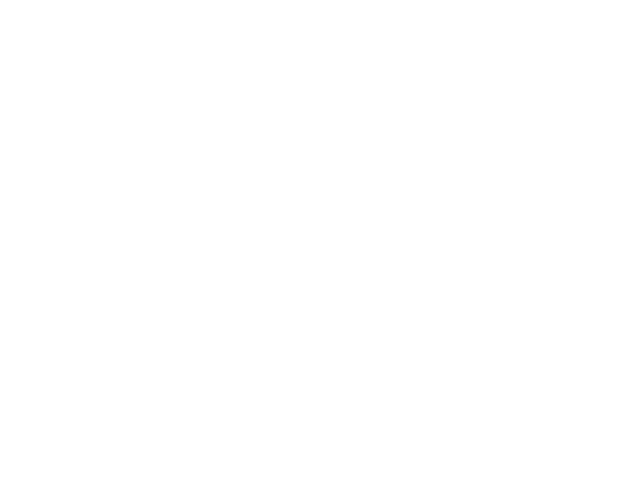

In [13]:
sns.boxplot(y = 'trip_times' , data = frame_with_duration)
plt.show()

In [15]:
for i in range(0,100,10):
    var = frame_with_duration["trip_times"].values
    var = np.sort(var , axis = None)
    print("{} percetile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100th percentile is {}".format(var[-1]))

0 percetile value is -43.95
10 percetile value is 3.933333333333333
20 percetile value is 5.566666666666666
30 percetile value is 7.1
40 percetile value is 8.683333333333334
50 percetile value is 10.466666666666667
60 percetile value is 12.55
70 percetile value is 15.2
80 percetile value is 18.933333333333334
90 percetile value is 25.516666666666666
100th percentile is 119912.7


In [16]:
for i in range(90,100):
    var = frame_with_duration["trip_times"].values
    var = np.sort(var , axis = None)
    print("{} percetile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100th percentile is {}".format(var[-1]))

90 percetile value is 25.516666666666666
91 percetile value is 26.55
92 percetile value is 27.733333333333334
93 percetile value is 29.116666666666667
94 percetile value is 30.733333333333334
95 percetile value is 32.7
96 percetile value is 35.233333333333334
97 percetile value is 38.666666666666664
98 percetile value is 43.916666666666664
99 percetile value is 53.9
100th percentile is 119912.7


In [21]:
for i in np.arange(0.0,1.0,0.1):
    var = frame_with_duration["trip_times"].values
    var = np.sort(var , axis = None)
    print("{} percetile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100th percentile is {}".format(var[-1]))

99.0 percetile value is 53.9
99.1 percetile value is 55.53333333333333
99.2 percetile value is 57.38333333333333
99.3 percetile value is 59.61666666666667
99.4 percetile value is 62.21666666666667
99.5 percetile value is 65.45
99.6 percetile value is 69.88333333333334
99.7 percetile value is 76.56666666666666
99.8 percetile value is 92.31666666666666
99.9 percetile value is 1424.05
100th percentile is 119912.7


In [23]:
frame_with_durations_modified=frame_with_duration[(frame_with_duration.trip_times>1) & (frame_with_duration.trip_times<720)]

<IPython.core.display.Javascript object>


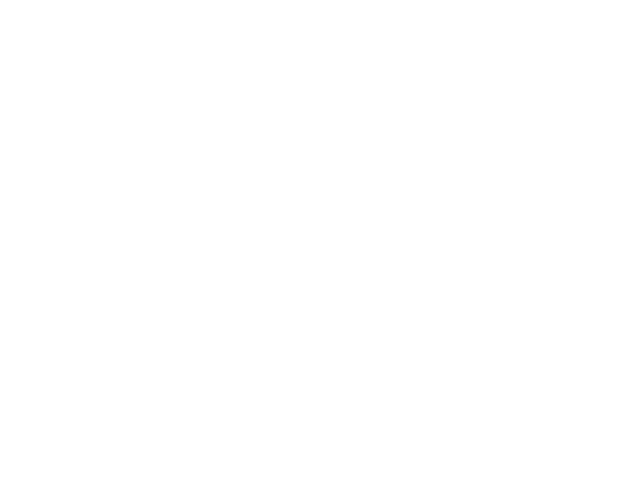

In [24]:
#speed
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()


In [25]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.33428165007113
99.1 percentile value is 35.89123867069487
99.2 percentile value is 36.49769585253456
99.3 percentile value is 37.17507418397626
99.4 percentile value is 37.91878172588833
99.5 percentile value is 38.762376237623755
99.6 percentile value is 39.768642447418735
99.7 percentile value is 41.019230769230774
99.8 percentile value is 42.63212435233161
99.9 percentile value is 45.163636363636364
100 percentile value is  41917233.8028169


In [27]:
frame_with_durations_modified=frame_with_duration[(frame_with_duration.Speed>0) & (frame_with_duration.Speed<45.16)]

In [28]:
#trip distance
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.59
99.1 percentile value is 18.8
99.2 percentile value is 19.01
99.3 percentile value is 19.3
99.4 percentile value is 19.61
99.5 percentile value is 20.0
99.6 percentile value is 20.5
99.7 percentile value is 21.0
99.8 percentile value is 21.78
99.9 percentile value is 23.89
100 percentile value is  191.9


In [30]:
frame_with_durations_modified=frame_with_duration[(frame_with_duration.trip_distance>0) & (frame_with_duration.trip_distance<24)]

<IPython.core.display.Javascript object>


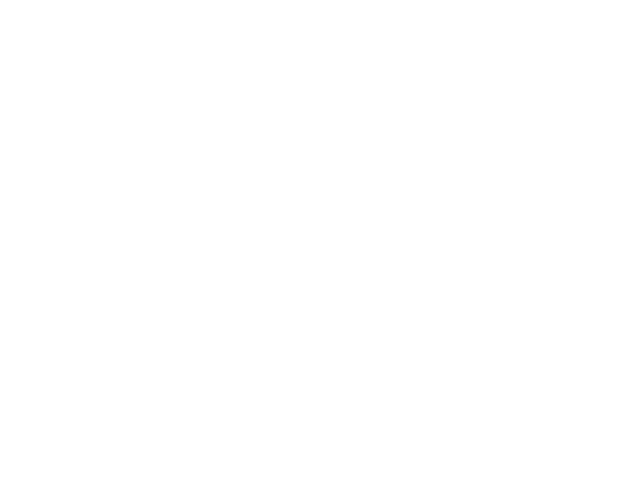

In [31]:
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

In [32]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [34]:
print ("Removing outliers in the month of Jan-2016")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_duration)
#print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_duration))

Removing outliers in the month of Jan-2016
----
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---


NameError: name 'frame_with_durations' is not defined

In [35]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

In [36]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

<IPython.core.display.Javascript object>


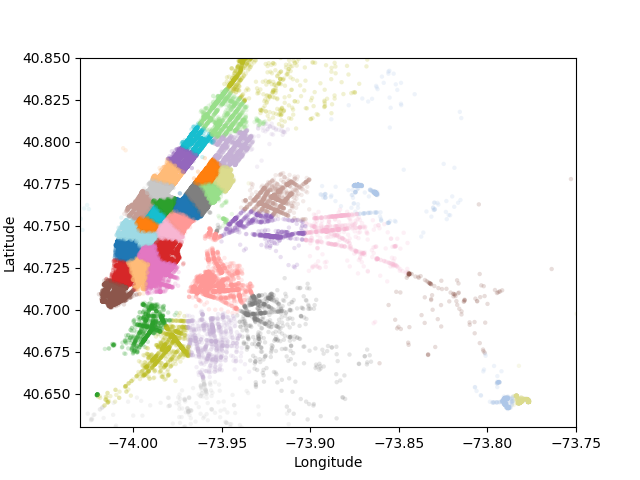

In [37]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

In [38]:
frame_with_durations_outliers_removed.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.50,1.451587e+09,17.902703,27
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.75,1.451587e+09,16.710280,6
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.90,1.451587e+09,6.050420,27
8,1,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,11.20,1.451587e+09,32.142857,18
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.10,1.451587e+09,17.351351,6


In [46]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [47]:
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2016_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2016)
jan_2016_groupby = jan_2016_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [77]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
        #print(list_unq)
    return values

In [78]:
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)
len(jan_2016_unique[0])

4383

In [69]:
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2016_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  81
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  72
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  596
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  424
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  86
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  81
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  83
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  86
-----------

In [79]:
jan_2016_groupby['trip_distance'].values

array([183, 265, 288, ...,  42,  48,  38], dtype=int64)

In [80]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [81]:
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [83]:
#Filling Missing values of Jan-2016 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2016_fill = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)

#Smoothing Missing values of Jan-2016
jan_2016_smooth = smoothing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)

<IPython.core.display.Javascript object>


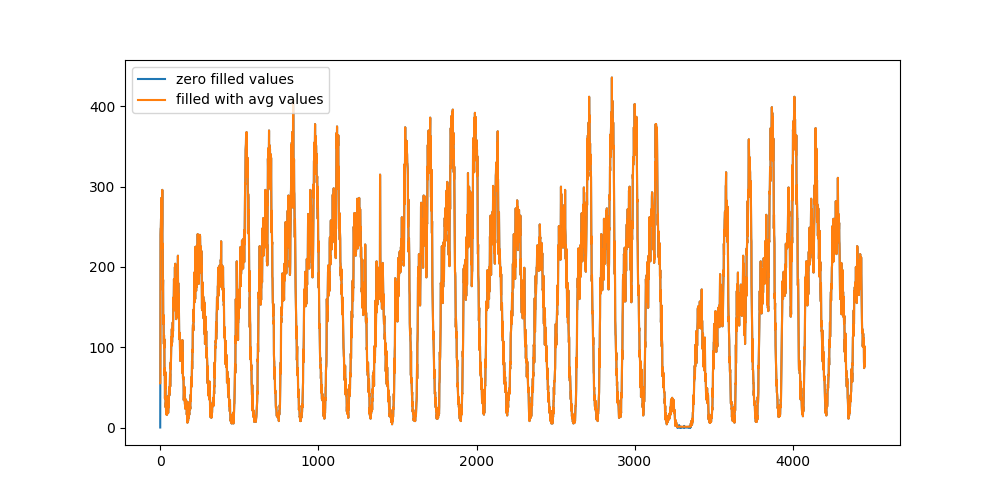

In [88]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2016_fill[4464:8920], label="zero filled values")
plt.plot(jan_2016_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


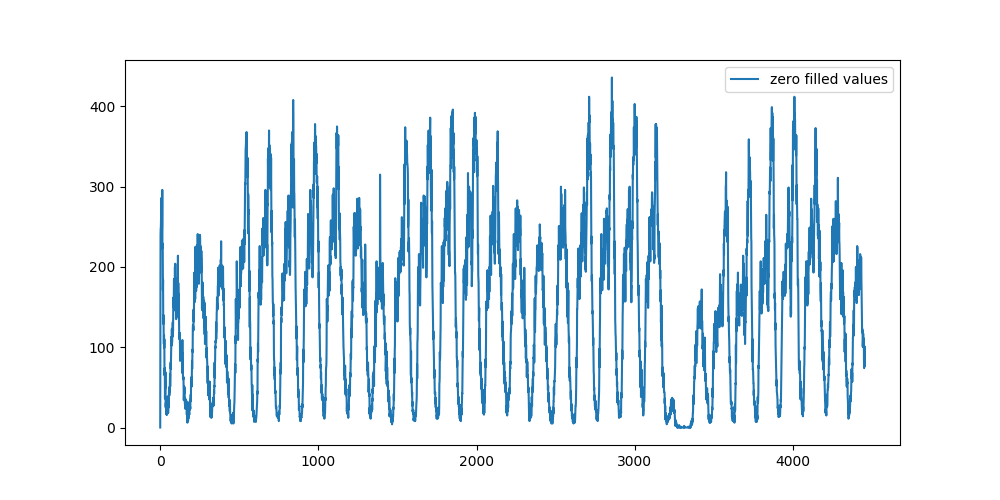

In [89]:
plt.figure(figsize=(10,5))
plt.plot(jan_2016_fill[4464:8920], label="zero filled values")
#plt.plot(jan_2016_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


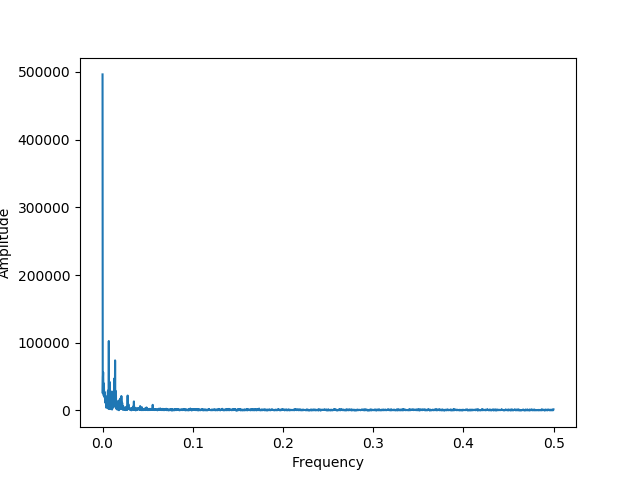

In [91]:
#fft
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [92]:
ratios_jan = pd.DataFrame()
ratios_jan['Prediction']=jan_2016_smooth

In [93]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [94]:
#weighted moving avg Prediction
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [95]:
#exponential weighted moving avg
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [96]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [97]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (2016 Values) -                        MAPE:  0.1394822417648615        MSE:  176.30917338709676
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (2016 Values) -               MAPE:  0.13244325614280691       MSE:  164.1469254032258
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (2016 Values) -         MAPE:  0.13235312261804266       MSE:  162.33272849462367
